# Modelo - Qual o próximo hit do Spotify?

Este projeto visa desenvolver um modelo preditivo que possa auxiliar na identificação de músicas com maior probabilidade de popularidade no Spotify. Utilizando um conjunto de dados com mais de 100 mil músicas, contendo tanto características acústicas (como energia, valência, e tempo) quanto metadados (gênero, ano de lançamento, etc.), o objetivo é prever a popularidade das faixas com base nesses atributos.

## Importação das bibliotecas

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Carregamento dos dados

In [52]:
# importação dos dataframes de treino e teste
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Pré-processamento

### Tratamento de valores nulos

Primeiramente, realiza-se a análise do número de valores nulos presentes em ambas as bases:

In [53]:
# Imprime o número de valores nulos em cada coluna da base de treino
df_train.isnull().sum()

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

### Identificação e Tratamento de outliers

In [23]:
# Selecionar as colunas numéricas que você deseja calcular o Z-score
numeric_columns = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Calcular a média e o desvio padrão para cada coluna no treino
mean = df_train[numeric_columns].mean()
std = df_train[numeric_columns].std()

# Calcular o Z-score no treino
z_scores_train = (df_train[numeric_columns] - mean) / std

# Identificar os outliers no treino
outliers_train = z_scores_train[(z_scores_train.abs() > 3)].count()

# Exibir os outliers no treino
print("Outliers no treino:\n", outliers_train)

Outliers no treino:
 duration_ms          699
danceability          99
energy                 0
loudness            1730
speechiness         1464
acousticness           0
instrumentalness       0
liveness            2553
valence                0
tempo                126
dtype: int64


Observando o número de outliers para a base de treino e teste acima, para cada uma das colunas, tomam-se diferentes abordagens para tratá-los. Primeiramente, devido o pequeno volume de outliers nas colunas `danceability` e `tempo`, optou-se por remover as linhas das bases com esses outliers.

In [49]:
# Calcular o Z-score para as colunas 'danceability' e 'tempo'
z_scores_danceability_train = z_scores_train['danceability']
z_scores_tempo_train = z_scores_train['tempo']

# Filtrar as linhas onde o Z-score é menor ou igual a 3 (ou maior ou igual a -3) para ambas as colunas
df_train = df_train[(z_scores_danceability_train.abs() <= 3) & (z_scores_tempo_train.abs() <= 3)]

# Verificar o número de linhas após a remoção dos outliers
print(f"Número de linhas após remoção dos outliers: {df_train.shape[0]}")


Número de linhas após remoção dos outliers: 79674


A capagem foi aplicada nas colunas `duration_ms` e `liveness`. Optou-se por limitar os valores dessas variáveis dentro dos percentis 1 e 99 para reduzir o impacto dos valores extremos, mantendo os dados mais consistentes e representativos da maioria das músicas.

In [56]:
# Definir os limites de capagem com base nos percentis 1 e 99 do conjunto de treino
for col in ['duration_ms', 'liveness']:
    lower_cap = df_train[col].quantile(0.01)
    upper_cap = df_train[col].quantile(0.99)
    
    # Aplicar os limites no treino
    df_train[col] = np.clip(df_train[col], lower_cap, upper_cap)


Nas colunas `loudness` e `speechiness`, a quantidade de outliers era significativa, e esses valores extremos poderiam ser influenciados por particularidades de mixagem ou pela presença de muito conteúdo falado. Para suavizar essa distorção, substituiu-se os outliers pela mediana.

In [57]:
# Substituir outliers pela mediana no treino e teste para 'loudness' e 'speechiness'
for col in ['loudness', 'speechiness']:
    median_train = df_train[col].median()
    
    # Substituir outliers no treino
    df_train.loc[z_scores_train[col].abs() > 3, col] = median_train

### Codificação das Variáveis Categóricas

In [58]:
# Identificar colunas não numéricas
categorical_columns = df_train.select_dtypes(include=['object']).columns
print("Colunas categóricas:", categorical_columns)

Colunas categóricas: Index(['track_id', 'artists', 'album_name', 'track_name', 'track_genre'], dtype='object')


In [59]:
# Aplicar Label Encoding às colunas categóricas
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

## Exploração e Visualização dos Dados

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79674 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79674 non-null  int64  
 1   track_id           79674 non-null  int64  
 2   artists            79674 non-null  int64  
 3   album_name         79674 non-null  int64  
 4   track_name         79674 non-null  int64  
 5   duration_ms        79674 non-null  float64
 6   explicit           79674 non-null  bool   
 7   danceability       79674 non-null  float64
 8   energy             79674 non-null  float64
 9   key                79674 non-null  int64  
 10  loudness           79674 non-null  float64
 11  mode               79674 non-null  int64  
 12  speechiness        79674 non-null  float64
 13  acousticness       79674 non-null  float64
 14  instrumentalness   79674 non-null  float64
 15  liveness           79674 non-null  float64
 16  valence            79674 no

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34124 entries, 0 to 34199
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_unique_id   34124 non-null  int64  
 1   track_id          34124 non-null  int64  
 2   artists           34124 non-null  int64  
 3   album_name        34124 non-null  int64  
 4   track_name        34124 non-null  int64  
 5   duration_ms       34124 non-null  float64
 6   explicit          34124 non-null  bool   
 7   danceability      34124 non-null  float64
 8   energy            34124 non-null  float64
 9   key               34124 non-null  int64  
 10  loudness          34124 non-null  float64
 11  mode              34124 non-null  int64  
 12  speechiness       34124 non-null  float64
 13  acousticness      34124 non-null  float64
 14  instrumentalness  34124 non-null  float64
 15  liveness          34124 non-null  float64
 16  valence           34124 non-null  float64
 17

In [33]:
df_train.describe()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
count,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000,79674.000000
mean,57091.421618,33318.673256,12871.359113,18081.058137,27551.375468,225968.412209,0.568063,0.642204,5.306938,-7.793298,0.637648,0.073797,0.314735,0.156620,0.212910,0.474836,122.203235,3.907435,56.591874,0.487951
std,32977.917447,19240.989047,7430.624197,10749.740598,15851.452479,81618.380262,0.172042,0.250776,3.561616,3.992034,0.480683,0.065526,0.332326,0.310143,0.188746,0.258604,29.604051,0.412066,32.976597,0.499858
min,0.000000,0.000000,0.000000,0.000000,0.000000,65276.220000,0.053200,0.000020,0.000000,-23.370000,0.000000,0.022100,0.000000,0.000000,0.040700,0.000000,34.262000,0.000000,0.000000,0.000000
25%,28412.750000,16663.250000,6492.000000,8810.250000,14050.250000,174560.000000,0.457000,0.473000,2.000000,-9.638000,0.000000,0.036000,0.017000,0.000000,0.097900,0.262000,99.270250,4.000000,28.000000,0.000000
50%,57165.000000,33307.500000,12771.500000,18023.000000,27390.500000,212888.000000,0.581000,0.686000,5.000000,-7.006250,1.000000,0.049000,0.168500,0.000040,0.132000,0.464000,122.014000,4.000000,57.000000,0.000000
75%,85692.750000,49982.750000,19330.000000,27279.750000,41147.750000,261504.500000,0.695000,0.854000,8.000000,-4.997000,1.000000,0.079800,0.597000,0.049100,0.273000,0.684000,140.055000,4.000000,85.000000,1.000000
max,113998.000000,66597.000000,25730.000000,37262.000000,55655.000000,528410.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.401000,0.996000,1.000000,0.944000,0.995000,210.962000,5.000000,113.000000,1.000000


In [34]:
df_test.describe()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
count,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000,34124.000000
mean,56604.317987,15627.459530,7672.772711,10002.627564,13679.448453,225916.022674,0.566646,0.641891,5.314559,-7.780724,0.637088,0.073534,0.314494,0.152225,0.213532,0.474384,122.472183,3.914195,56.105087
std,32683.862833,9016.682778,4382.067733,5925.564907,7847.665801,82142.853444,0.173067,0.250774,3.554193,3.980424,0.480847,0.065340,0.332323,0.305753,0.189421,0.259308,29.590024,0.397615,32.683140
min,3.000000,0.000000,0.000000,0.000000,0.000000,65276.220000,0.051300,0.000020,0.000000,-23.370000,0.000000,0.022100,0.000000,0.000000,0.040700,0.000000,35.790000,0.000000,0.000000
25%,28584.750000,7825.750000,3951.000000,4892.000000,6971.750000,173565.000000,0.456000,0.473000,2.000000,-9.667000,0.000000,0.035800,0.016600,0.000000,0.098100,0.257000,99.773000,4.000000,28.000000
50%,56397.500000,15641.500000,7669.500000,9895.000000,13642.500000,213293.000000,0.579000,0.683000,5.000000,-6.976000,1.000000,0.048700,0.168000,0.000043,0.133000,0.464000,122.067000,4.000000,56.000000
75%,84697.500000,23418.250000,11408.000000,15087.250000,20426.250000,261732.000000,0.694000,0.853000,8.000000,-5.004000,1.000000,0.080000,0.596000,0.044325,0.273000,0.683000,140.205250,4.000000,84.000000
max,113999.000000,31257.000000,15274.000000,20543.000000,27471.000000,528410.000000,0.980000,1.000000,11.000000,1.795000,1.000000,0.401000,0.996000,1.000000,0.944000,0.992000,211.567000,5.000000,113.000000


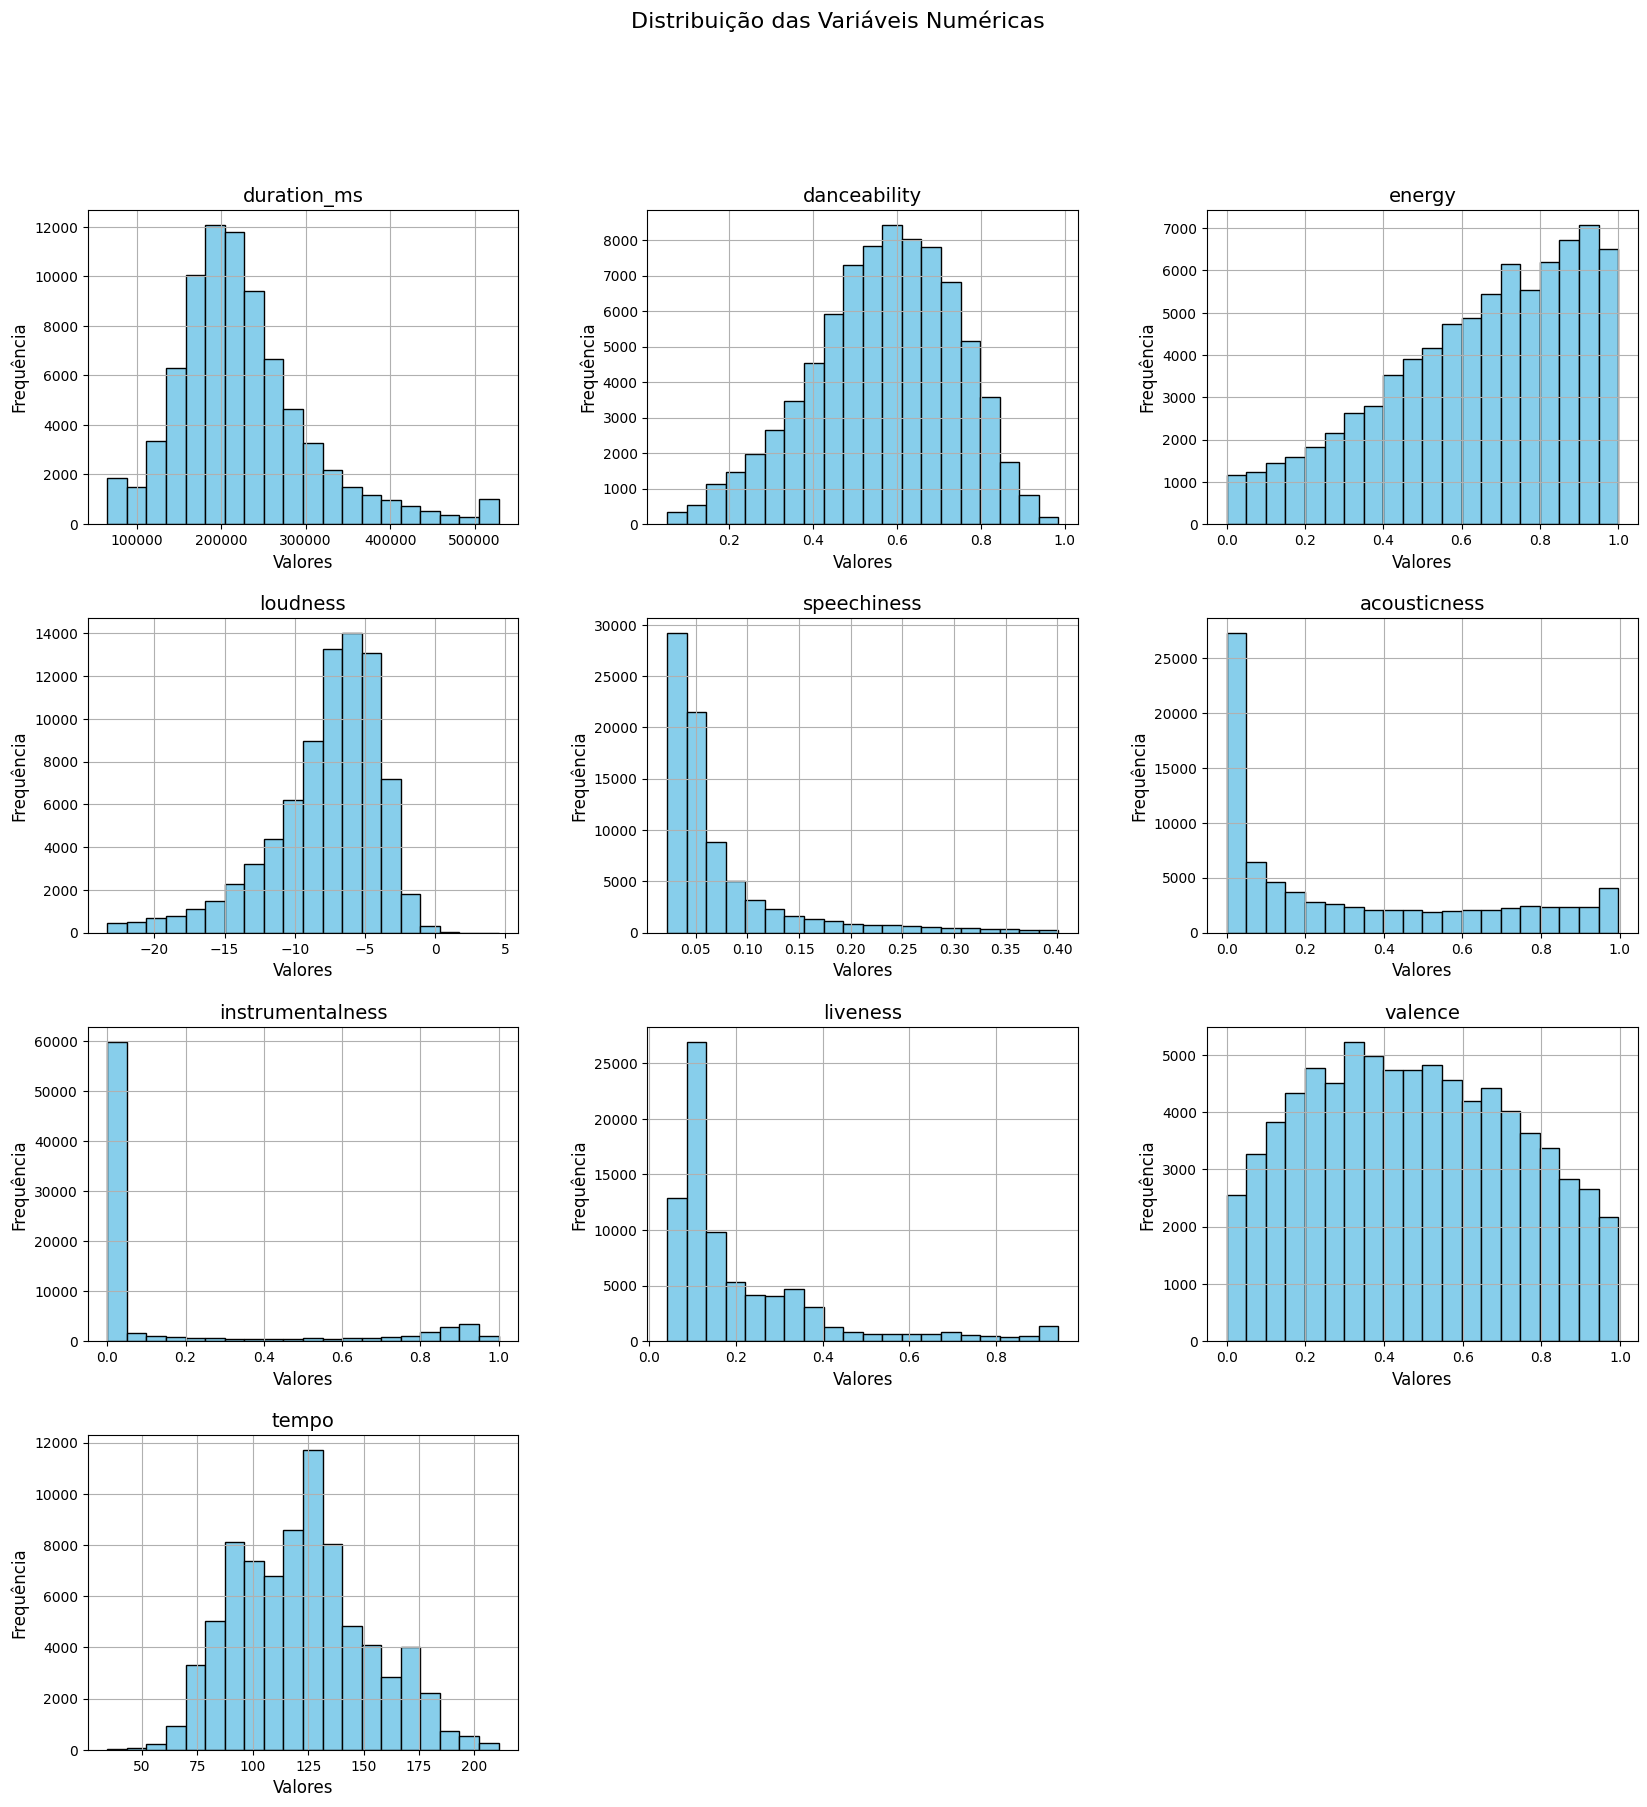

In [35]:
df_train[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].hist(bins=20, figsize=(20, 20), color='skyblue', edgecolor='black')

# Melhorar a apresentação
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)  # Título geral

# Adicionar rótulos de eixos e títulos a cada subplot
for ax in plt.gcf().axes:
    ax.set_xlabel('Valores', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.set_title(ax.get_title(), fontsize=14)  # Manter título da variável

# Exibir o histograma
plt.show()

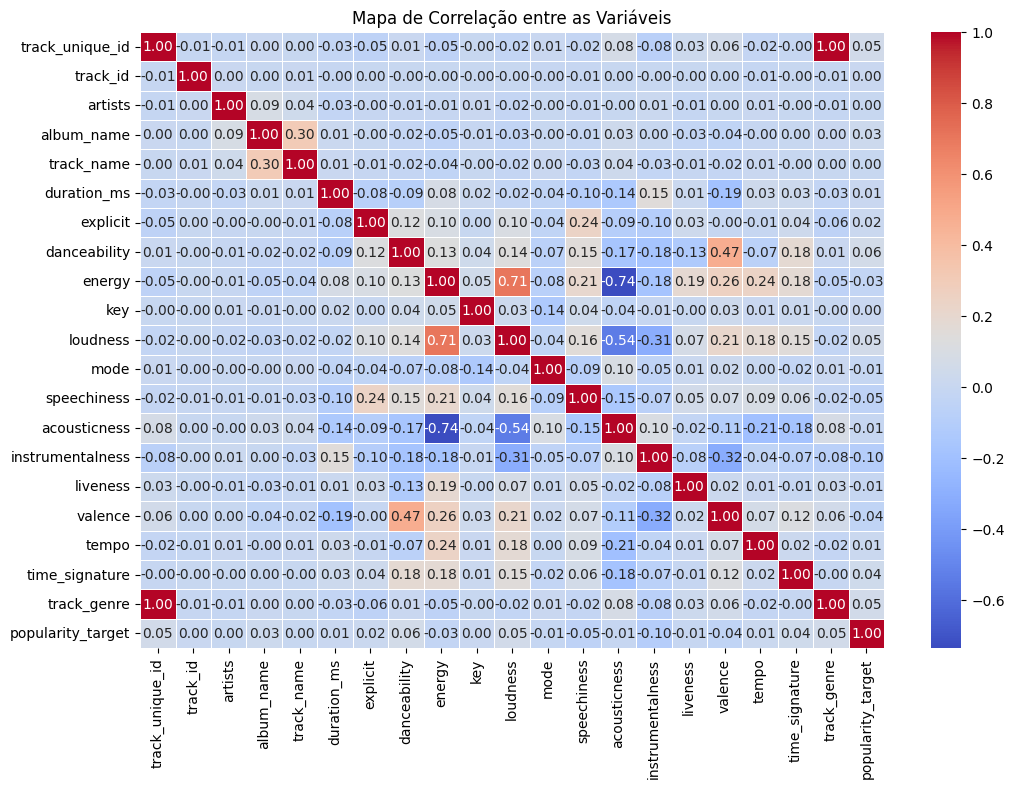

In [36]:
# Calculando a correlação entre as variáveis numéricas
corr_matrix = df_train.corr()

# Criando um heatmap de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Correlação entre as Variáveis')
plt.show()

## Hipóteses

**Hipótese 1:** Músicas de gêneros mais populares tendem a alcançar maior sucesso.

Músicas de gêneros mais populares, como pop, tendem a alcançar maior sucesso devido à sua ampla aceitação pelo público. A hipótese sugere que músicas pertencentes a esses estilos têm mais chances de serem amplamente ouvidas em comparação com gêneros mais nichados.


**Hipótese 2:** Músicas com uma energia alta têm maior probabilidade de serem populares.

Músicas enérgicas têm uma maior probabilidade de se tornarem populares, devido à sua compatibilidade com contextos sociais que demandam faixas animadas e contagiantes.

**Hipótese 3:** A duração da música afeta sua popularidade.

A duração das músicas pode influenciar diretamente sua popularidade. Músicas curtas, entre 2 e 3 minutos, tendem a ser mais populares, pois são mais fáceis de encaixar em playlists e em serviços de streaming. Músicas longas podem ser menos acessíveis ao público em geral, resultando em uma menor taxa de reprodução e, consequentemente, em menos popularidade.

## Escolha de features

popularity_target    1.000000
danceability         0.058210
track_genre          0.054513
track_unique_id      0.053947
loudness             0.053539
time_signature       0.038612
album_name           0.026459
explicit             0.016216
tempo                0.013582
duration_ms          0.007022
track_id             0.004661
key                  0.004055
track_name           0.002290
artists              0.000761
liveness            -0.008104
acousticness        -0.009002
mode                -0.013679
energy              -0.026086
valence             -0.043161
speechiness         -0.051766
instrumentalness    -0.101098
Name: popularity_target, dtype: float64


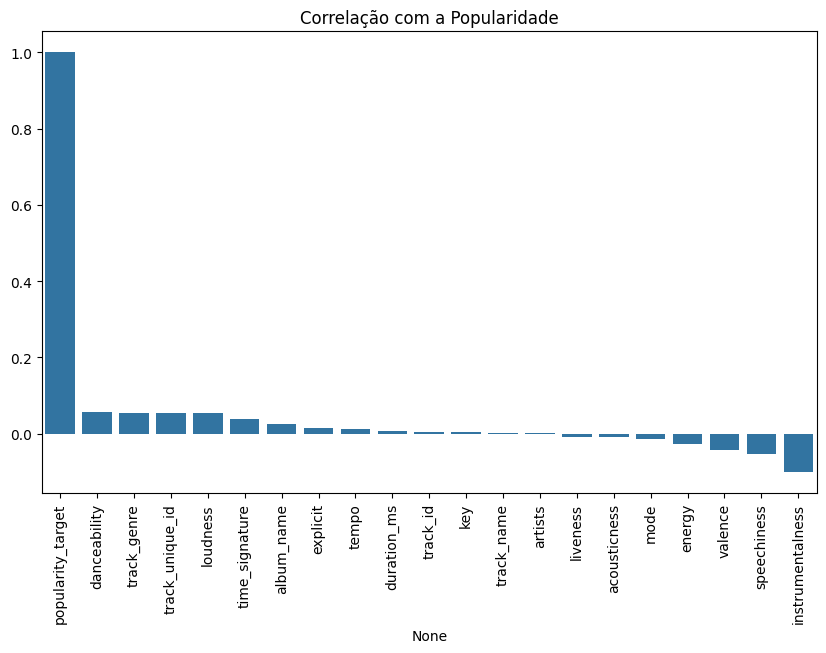

In [37]:
# Calcula a correlação de todas as colunas com a coluna alvo 'popularity_target'
correlation_matrix = df_train.corr()

# Filtra as correlações da coluna 'popularity_target'
target_correlation = correlation_matrix["popularity_target"].sort_values(ascending=False)

# Exibe as correlações
print(target_correlation)

# Visualiza as correlações em um gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values)
plt.title('Correlação com a Popularidade')
plt.xticks(rotation=90)
plt.show()


Com base na análise de correlação entre as variáveis e a popularidade das músicas, selecionei as features mais relevantes para o modelo, priorizando aquelas com maior impacto sobre a variável alvo. As variáveis como `danceability`, `track_genre` e `loudness` apresentaram correlação positiva com a popularidade, sugerindo que músicas com maior dançabilidade, volume e pertencentes a gêneros populares tendem a ser mais bem-sucedidas. Por outro lado, características como `instrumentalness` e `speechiness` mostraram correlação negativa, indicando que músicas com muitos elementos instrumentais e alto teor de fala são menos populares. Sendo assim, as features mantidas são aquelas que se referem a características diretamente relacionadas ao conteúdo acústico, técnico ou categórico da música, como gênero, energia, e duração. 

## Modelagem

In [38]:
X = df_train.drop(columns=['popularity_target', 'track_unique_id', 'track_id', 'track_name', 'artists', 'album_name'])  # Substitua pelo nome correto da coluna alvo
y = df_train['popularity_target']

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = RandomForestClassifier(random_state=42)
# Treinar o modelo
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia do modelo: 0.80

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      8313
           1       0.78      0.81      0.80      7622

    accuracy                           0.80     15935
   macro avg       0.80      0.80      0.80     15935
weighted avg       0.80      0.80      0.80     15935



## Finetuning de Hiperparâmetros

In [41]:
param_dist = {
    'n_estimators': [100, 200],            # Mantendo apenas duas opções para n_estimators
    'max_depth': [10, 20],                 # Diminuindo as opções de max_depth
    'min_samples_split': [2, 5],           # Mantendo apenas duas opções para min_samples_split
}

# Reduzindo o número de iterações e número de dobras de validação cruzada
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_dist, 
                                   n_iter=10,          # Diminuir o número de iterações
                                   cv=3,               # Usando validação cruzada com 3 dobras
                                   scoring='accuracy', 
                                   random_state=42, 
                                   n_jobs=-1)           # Utilizando todos os núcleos disponíveis

# Treinando a busca aleatória
random_search.fit(X_train, y_train)

# Melhor modelo encontrado
print("Melhores parâmetros:", random_search.best_params_)


c:\Users\Inteli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores parâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}


In [42]:
# Criar um novo modelo RandomForest com os melhores parâmetros
model_tuned = RandomForestClassifier(
    n_estimators=random_search.best_params_['n_estimators'],
    max_depth=random_search.best_params_['max_depth'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    random_state=42
)

# Treinar o modelo ajustado com os dados de treino
model_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [60]:
# Fazer previsões com o modelo ajustado
y_pred_tuned = model_tuned.predict(X_test)

# Avaliar a acurácia do modelo ajustado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Acurácia do modelo ajustado: {accuracy_tuned:.2f}")

# Relatório de classificação do modelo ajustado
print("\nRelatório de Classificação (Modelo Ajustado):")
print(classification_report(y_test, y_pred_tuned))

Acurácia do modelo ajustado: 0.79

Relatório de Classificação (Modelo Ajustado):
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      8313
           1       0.76      0.82      0.79      7622

    accuracy                           0.79     15935
   macro avg       0.79      0.79      0.79     15935
weighted avg       0.79      0.79      0.79     15935



## Previsões da Base de teste

In [61]:
# Fazer previsões com o modelo ajustado (apenas as features que você utilizou para o treino)
X_test_final = df_test.drop(columns=['track_unique_id', 'track_id', 'track_name', 'artists', 'album_name'])

# Prever a popularidade (popularity_target) usando o modelo ajustado
y_pred_final = model.predict(X_test_final)

In [64]:
# Criar um DataFrame com as previsões
output = pd.DataFrame({
    'track_unique_id': df_test['track_unique_id'],
    'popularity_target': y_pred_final
})

# Salvar o arquivo CSV com as previsões
output.to_csv('submission.csv', index=False)

print("Arquivo 'submission.csv' gerado")

Arquivo 'submission.csv' gerado
